In [1]:
import os, sys
import re, json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',2000)

In [14]:
hdb = pd.read_excel('./output/HDB_resale_prices.xlsx')

In [15]:
hdb.shape

(21340, 10)

In [16]:
hdb.columns

Index(['Town', 'Room Type', 'Block', 'Street', 'Storey',
       'Lease Commencement Date', 'Remaining Lease',
       'Resale Registration Date', 'Price', 'Sqm'],
      dtype='object')

In [17]:
hdb['Street'] = hdb['Street'].str.strip()

In [18]:
flat_type_conversion = {1:'1-Room',2:'2-Room',3:'3-Room',4:'4-Room',5:'5-Room',6:'Executive',8:'Multi-Generation'}

In [19]:
hdb.replace({'Room Type': flat_type_conversion}, inplace=True)

In [20]:
hdb.head()

,Town,Room Type,Block,Street,Storey,Lease Commencement Date,Remaining Lease,Resale Registration Date,Price,Sqm
0,AMK Ang Mo Kio,2-Room,314,Ang Mo Kio Ave 3,04 to 06,1978,56 years\n7 months,Jul 2020,"$198,000.00",44.00\nImproved
1,AMK Ang Mo Kio,2-Room,406,Ang Mo Kio Ave 10,07 to 09,1979,58 years\n1 month,Jun 2020,"$200,000.00",44.00\nImproved
2,AMK Ang Mo Kio,2-Room,323,Ang Mo Kio Ave 3,07 to 09,1977,56 years\n2 months,Jun 2020,"$196,000.00",44.00\nImproved
3,AMK Ang Mo Kio,2-Room,174,Ang Mo Kio Ave 4,04 to 06,1986,64 years\n8 months,Jun 2020,"$205,000.00",45.00\nImproved
4,AMK Ang Mo Kio,2-Room,510,Ang Mo Kio Ave 8,07 to 09,1980,59 years\n1 month,Jun 2020,"$199,000.00",44.00\nImproved


In [21]:
def getRemainingLeaseYear(row):
    r = row.split('\n')[0]
    r = re.search('\d+', r).group()
    return int(r)

In [22]:
def getRemainingLeaseMonth(row):
    r = row.split('\n')
    if len(r) > 1:
        r = r[1]
        r = re.search('\d+', r).group()
        return int(r)
    else:
        return int(0)

In [23]:
hdb['Remaining Lease (Year)'] = hdb['Remaining Lease'].apply(getRemainingLeaseYear)
hdb['Remaining Lease (Month)'] = hdb['Remaining Lease'].apply(getRemainingLeaseMonth)
hdb['Remaining Lease in Months'] = hdb['Remaining Lease (Year)']*12 + hdb['Remaining Lease (Month)']

In [24]:
def getFloorArea(row):
    return float(row.split('\n')[0])

def getModelType(row):
    try:
        r = row.split('\n')[1]
        return r
    except:
        return None

hdb['Sqm'] = hdb['Sqm'].apply(getFloorArea)
hdb['Model Type'] = hdb['Sqm'].apply(getModelType)

In [25]:
def cleanPrice(row):
    r = re.sub('[^0-9]','',row)
    return float(r.strip('$'))/100

hdb['Price'] = hdb['Price'].apply(cleanPrice)
hdb['Price'] = hdb['Price'].astype(float)

In [26]:
def getTownName(row):
    r = row.split()[1:]
    return ' '.join(r)

hdb['Town Name'] = hdb['Town'].apply(getTownName)

In [28]:
SQM_to_SQFT = 10.764
hdb['Sqft'] = hdb['Sqm']*SQM_to_SQFT
hdb['Price per Sqm'] = hdb['Price']/hdb['Sqm']
hdb['Price per Sqft'] = hdb['Price']/hdb['Sqft']

In [30]:
hdb['Storey + Room Type'] = hdb['Storey'] + ' ' + hdb['Room Type']

In [31]:
hdb.head(3)

,Town,Room Type,Block,Street,Storey,Lease Commencement Date,Remaining Lease,Resale Registration Date,Price,Sqm,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Model Type,Town Name,Sqft,Price per Sqm,Price per Sqft,Storey + Room Type
0,AMK Ang Mo Kio,2-Room,314,Ang Mo Kio Ave 3,04 to 06,1978,56 years\n7 months,Jul 2020,198000.0,44.0,56,7,679,None,Ang Mo Kio,473.616,4500.000000,418.060201,04 to 06 2-Room
1,AMK Ang Mo Kio,2-Room,406,Ang Mo Kio Ave 10,07 to 09,1979,58 years\n1 month,Jun 2020,200000.0,44.0,58,1,697,None,Ang Mo Kio,473.616,4545.454545,422.283031,07 to 09 2-Room
2,AMK Ang Mo Kio,2-Room,323,Ang Mo Kio Ave 3,07 to 09,1977,56 years\n2 months,Jun 2020,196000.0,44.0,56,2,674,None,Ang Mo Kio,473.616,4454.545455,413.837370,07 to 09 2-Room


In [32]:
hdb['Resale Registration Date'] = pd.to_datetime(hdb['Resale Registration Date'], format='%b %Y')
hdb['Resale Registration Date'] = hdb['Resale Registration Date'].apply(lambda x: datetime.strftime(x, '%b %Y'))

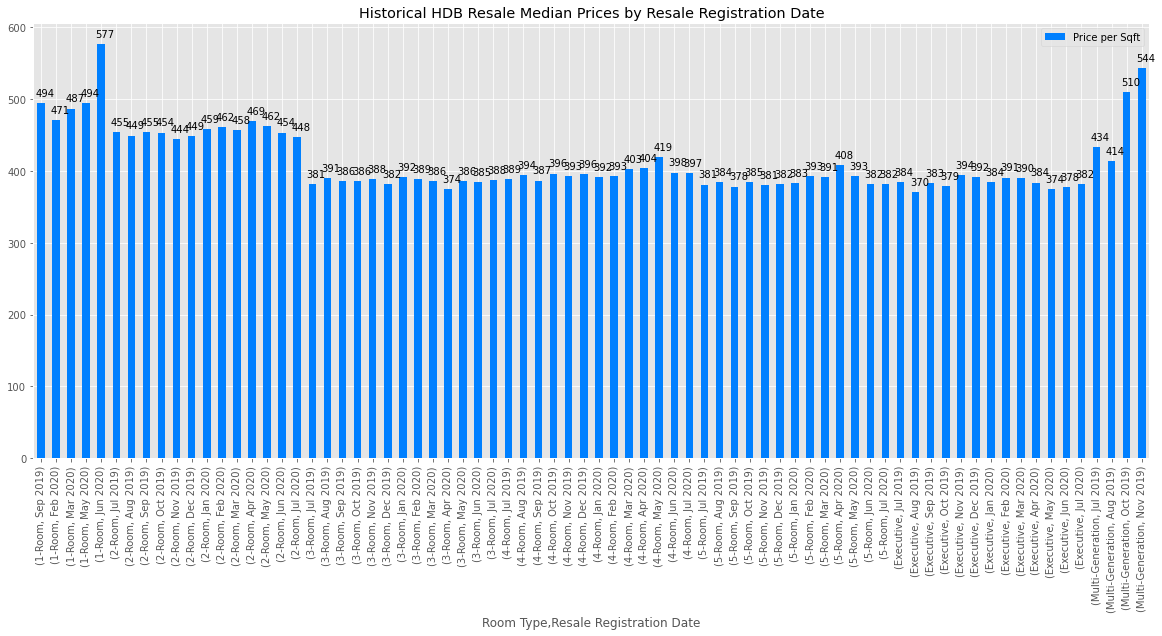

In [116]:
hdb_median_prices_bytime = hdb.groupby(['Room Type','Resale Registration Date']).agg({'Price per Sqft':'median'}).reset_index()
hdb_median_prices_bytime['Resale Registration Date'] =  pd.to_datetime(hdb_median_prices_bytime['Resale Registration Date'], format='%b %Y')
hdb_median_prices_bytime = hdb_median_prices_bytime.sort_values(by=['Room Type','Resale Registration Date'], ascending=True)
hdb_median_prices_bytime['Resale Registration Date'] = hdb_median_prices_bytime['Resale Registration Date'].apply(lambda x: datetime.strftime(x, '%b %Y'))
hdb_median_prices_bytime.set_index(['Room Type','Resale Registration Date'], inplace=True)
ax = hdb_median_prices_bytime.plot(kind='bar', figsize=(20,8), color = '#0080FF')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width, y+height),\
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_title('Historical HDB Resale Median Prices by Resale Registration Date')
plt.show()

## Historial HDB Resale Median Prices psf over the past 12 months

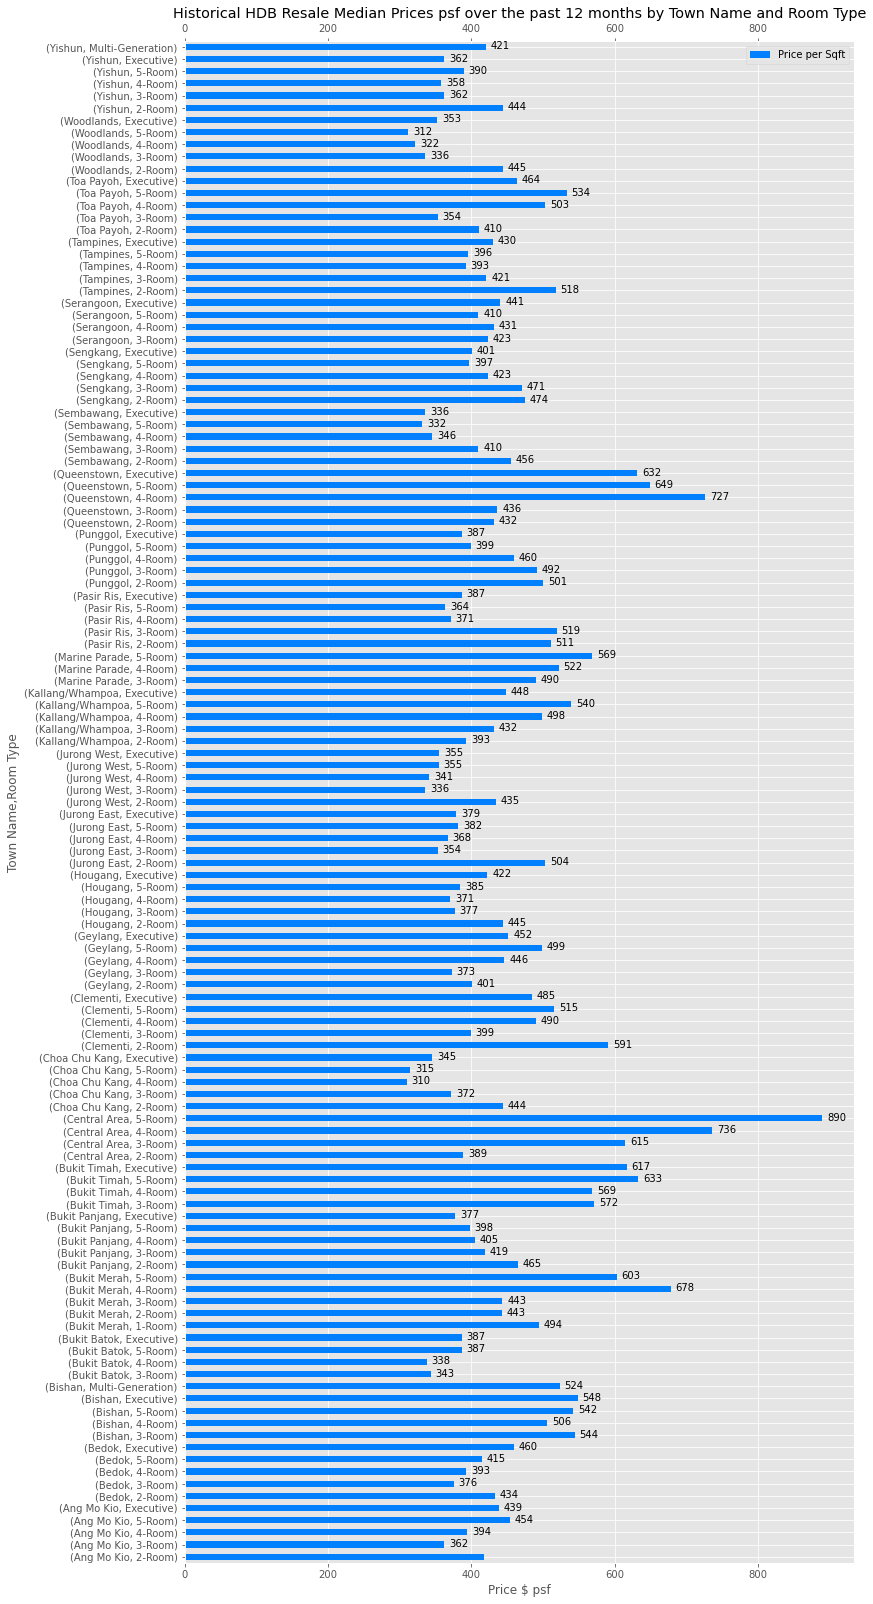

In [114]:
hdb_median_prices = hdb.groupby(['Town Name','Room Type']).agg({'Price per Sqft':'median'})
ax = hdb_median_prices.plot(kind = 'barh', figsize=(12,28), color='#0080FF')
# plt.suptitle(f"Median Price psf by Town", fontsize=18)
ax.set_xlabel("Price $ psf", fontsize=12)
ax.set_title(f'Historical HDB Resale Median Prices psf over the past 12 months by Town Name and Room Type')
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if width > 0 and width < np.inf:
        ax.annotate(int(round(width)),\
                    (x+width+20, y-0.5),\
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

## Remaining Lease Year by Town

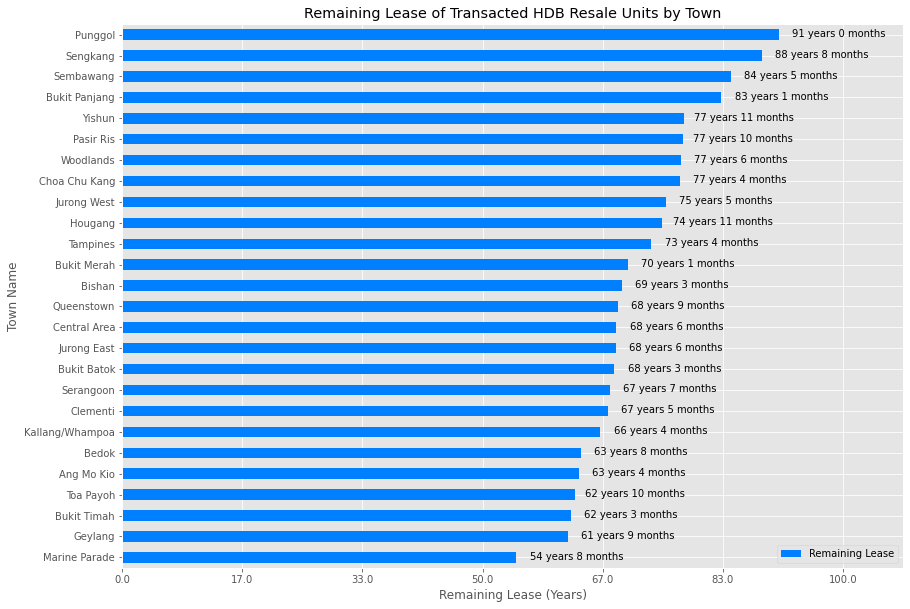

In [107]:
remaining_lease = hdb.groupby('Town Name').agg({'Remaining Lease in Months':'mean'}).reset_index()
remaining_lease['Remaining Lease in Years'] = remaining_lease['Remaining Lease in Months']//12
remaining_lease['Remaining Lease in (Months)'] = round(remaining_lease['Remaining Lease in Months']%12)
remaining_lease['Remaining Lease'] = remaining_lease['Remaining Lease in Years'].astype(int).astype(str) + ' years ' + remaining_lease['Remaining Lease in (Months)'].astype(int).astype(str) + ' months'
remaining_lease = remaining_lease.sort_values(by = 'Remaining Lease in Months')
ax = remaining_lease.plot(kind = 'barh', figsize=(14,10), color='#0080FF', x='Town Name', y='Remaining Lease in Months')
ax.set_xticklabels(np.round(np.arange(0,101,100/6)))
ax.legend(['Remaining Lease'])
ax.set_xlabel('Remaining Lease (Years)')
ax.set_xlim(0,1300)
cnt = 0
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if width > 0 and width < np.inf:
        ax.annotate(remaining_lease['Remaining Lease'].iloc[cnt],\
                    (x+width+100, y+height-0.7),\
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    cnt+=1

ax.set_title(f'Average Remaining Lease of Transacted HDB Resale Units by Town')

plt.show()

## Historical HDB Resale price at Street Level

In [136]:
hdb[hdb['Town Name'] == 'Queenstown'].Street.unique()

array(['Ghim Moh Rd', "C'wealth Cl", 'Ghim Moh Link', "C'wealth Cres",
       "C'wealth Dr", 'Dover Cres', 'Stirling Rd', 'Strathmore Ave',
       'Dawson Rd', 'Dover Rd', 'Holland Ave', 'Holland Dr',
       'Mei Ling St', 'Holland Cl', 'Tanglin Halt Rd', "C'wealth Ave",
       "Queen's Cl", 'Queensway', 'Clarence Lane', 'Dover Cl East'],
      dtype=object)

In [132]:
[x for x in hdb.Street.unique().tolist() if 'tamp' in x.lower()]

[]

In [117]:
[x for x in hdb.Street.unique().tolist() if 'daw' in x.lower()]

['Dawson Rd']

In [118]:
mystreet = 'Dawson Rd'
tamp = hdb[hdb['Street'].isin([mystreet])]

In [121]:
toplot = tamp.groupby(['Town Name','Storey','Room Type']).\
agg({'Town Name':'count', 'Price':['mean','median'], 'Price per Sqm':['mean','median'],\
                                                       'Price per Sqft':['mean','median']}).reset_index()
toplot.columns = ['Town Name','Storey','Room Type','Total Units','Average Price','Median Price',\
                  'Average Price per Sqm','Median Price per Sqm',\
                  'Average Price per Sqft','Median Price per Sqft']
toplot = toplot.round({'Average Price':2,'Median Price':2,\
                  'Average Price per Sqm':2,'Median Price per Sqm':2,\
                  'Average Price per Sqft':2,'Median Price per Sqft':2})
toplot['Storey + Room Type'] = toplot['Storey'] + ' ' + toplot['Room Type']

toplot

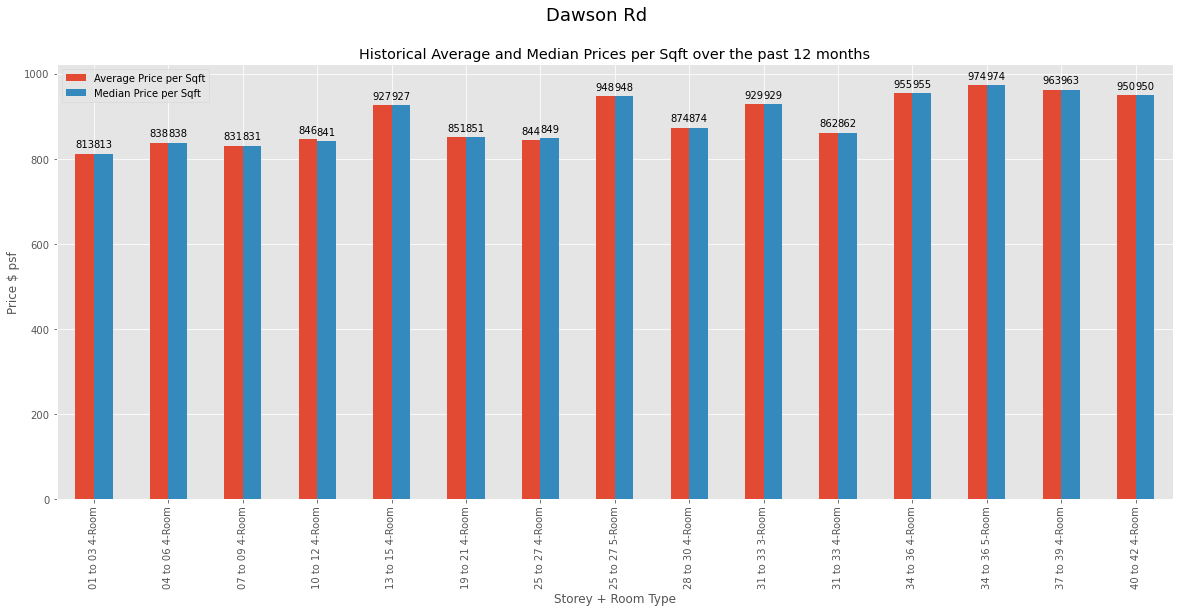

In [124]:
ax = toplot.plot(kind='bar', figsize=(20,8), x = 'Storey + Room Type', y=['Average Price per Sqft','Median Price per Sqft'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height),\
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.suptitle(f"{mystreet}", fontsize=18)
ax.set_ylabel("Price $ psf", fontsize=12)
ax.set_title(f'Historical Average and Median Prices per Sqft over the past 12 months')
plt.show()

In [126]:
mystreet = 'Tampines Ctrl 8'
tamp = hdb[hdb['Street'].isin([mystreet])]

In [127]:
toplot = tamp.groupby(['Town Name','Storey','Room Type']).\
agg({'Town Name':'count', 'Price':['mean','median'], 'Price per Sqm':['mean','median'],\
                                                       'Price per Sqft':['mean','median']}).reset_index()
toplot.columns = ['Town Name','Storey','Room Type','Total Units','Average Price','Median Price',\
                  'Average Price per Sqm','Median Price per Sqm',\
                  'Average Price per Sqft','Median Price per Sqft']
toplot = toplot.round({'Average Price':2,'Median Price':2,\
                  'Average Price per Sqm':2,'Median Price per Sqm':2,\
                  'Average Price per Sqft':2,'Median Price per Sqft':2})
toplot['Storey + Room Type'] = toplot['Storey'] + ' ' + toplot['Room Type']

toplot

,Town Name,Storey,Room Type,Total Units,Average Price,Median Price,Average Price per Sqm,Median Price per Sqm,Average Price per Sqft,Median Price per Sqft,Storey + Room Type
0,Tampines,01 to 03,4-Room,2,572500.00,572500.0,6815.48,6815.48,633.17,633.17,01 to 03 4-Room
1,Tampines,04 to 06,3-Room,2,476000.00,476000.0,7677.42,7677.42,713.25,713.25,04 to 06 3-Room
2,Tampines,04 to 06,4-Room,6,613166.67,612500.0,7329.25,7335.41,680.90,681.48,04 to 06 4-Room
3,Tampines,04 to 06,5-Room,1,800000.00,800000.0,7407.41,7407.41,688.16,688.16,04 to 06 5-Room
4,Tampines,07 to 09,3-Room,2,505500.00,505500.0,8153.23,8153.23,757.45,757.45,07 to 09 3-Room
5,Tampines,07 to 09,4-Room,10,637588.80,638500.0,7627.18,7601.19,708.58,706.17,07 to 09 4-Room
6,Tampines,07 to 09,5-Room,1,800000.00,800000.0,7407.41,7407.41,688.16,688.16,07 to 09 5-Room
7,Tampines,10 to 12,3-Room,3,503592.00,505000.0,8122.45,8145.16,754.59,756.70,10 to 12 3-Room
8,Tampines,10 to 12,4-Room,4,665000.00,667500.0,7940.69,7976.19,737.71,741.01,10 to 12 4-Room
9,Tampines,10 to 12,5-Room,1,842000.00,842000.0,7796.30,7796.30,724.29,724.29,10 to 12 5-Room


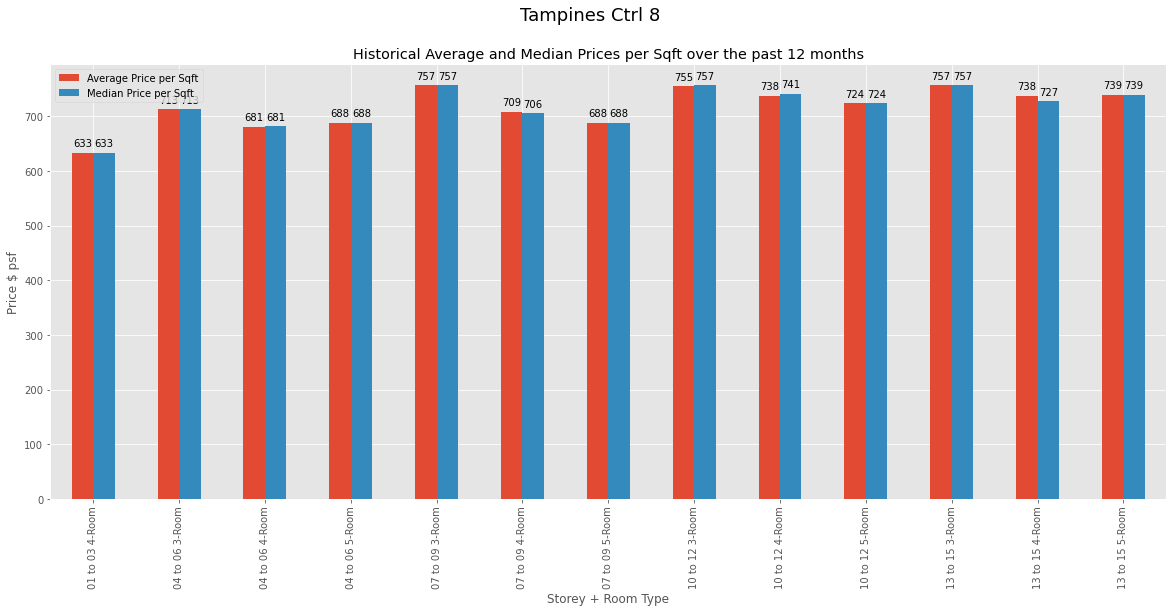

In [128]:
ax = toplot.plot(kind='bar', figsize=(20,8), x = 'Storey + Room Type', y=['Average Price per Sqft','Median Price per Sqft'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height),\
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.suptitle(f"{mystreet}", fontsize=18)
ax.set_ylabel("Price $ psf", fontsize=12)
ax.set_title(f'Historical Average and Median Prices per Sqft over the past 12 months')
plt.show()